In [1]:
# load packages
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

import pandas
import pickle

Using TensorFlow backend.
/Users/ianpg/anaconda/envs/AEM_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ianpg/anaconda/envs/AEM_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ianpg/anaconda/envs/AEM_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ianpg/anaconda/e

In [3]:
# import the data
data = pandas.read_pickle('../raw_processed_data/raw_processed.pkl')
dataShort = data.iloc[0:10,19:46].copy()
data

,TIMESTAMP,LINE_NO,UTMX,UTMY,ELEVATION,CHANNEL_NO,RX_ALTITUDE,RX_ALTITUDE_STD,TX_ALTITUDE,TX_ALTITUDE_STD,...,DBDT_INUSE_Ch2GT31,DBDT_INUSE_Ch2GT32,DBDT_INUSE_Ch2GT33,DBDT_INUSE_Ch2GT34,DBDT_INUSE_Ch2GT35,DBDT_INUSE_Ch2GT36,DBDT_INUSE_Ch2GT37,closest_pos,closest_ind,VALID
0,43434.663700,100101,573558.0,4395767.7,63.11,1,49.11,0.060,50.55,0.060,...,9999,9999,9999,9999,9999,9999,9999,12.776932,11198.0,True
1,43434.663712,100101,573558.5,4395758.1,63.15,2,48.99,0.060,50.82,0.060,...,1,1,1,1,1,0,1,3.228002,11198.0,True
2,43434.663715,100101,573559.3,4395755.2,63.16,1,48.89,0.060,50.76,0.060,...,9999,9999,9999,9999,9999,9999,9999,0.223607,11198.0,True
3,43434.663727,100101,573564.0,4395745.9,63.16,2,47.32,0.062,49.20,0.062,...,1,1,1,1,1,0,1,0.141421,11200.0,True
4,43434.663731,100101,573566.0,4395743.1,63.15,1,46.60,0.063,48.41,0.063,...,9999,9999,9999,9999,9999,9999,9999,3.580503,11200.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7316,43436.748160,710101,579762.1,4390268.5,45.84,1,61.36,0.050,57.98,0.050,...,9999,9999,9999,9999,9999,9999,9999,344.506734,11709.0,False
7317,43436.748172,710101,579763.7,4390244.7,45.84,2,54.92,0.056,51.78,0.056,...,0,0,0,0,0,0,1,361.668536,11709.0,False
7318,43436.748176,710101,579764.3,4390237.4,45.84,1,53.01,0.058,50.01,0.058,...,9999,9999,9999,9999,9999,9999,9999,366.785932,11711.0,False
7319,43436.748188,710101,579766.2,4390212.7,45.84,2,47.11,0.065,44.69,0.065,...,0,0,0,0,0,0,1,384.290957,11711.0,False


In [4]:
lineNumbers=np.unique(data["LINE_NO"])
timeDiff=np.diff(data["TIMESTAMP"])
timeDiffMask=timeDiff<5e-6

In [17]:
currData.CHANNEL_NO

0      2
1      1
2      2
3      1
4      2
      ..
705    1
706    2
707    1
708    2
709    1
Name: CHANNEL_NO, Length: 710, dtype: int64

In [5]:
# set the number of adjacent soundings to use
adSoundings=1;

# iterate through the line numbers
for line in lineNumbers:

    # make a mask for the rows in the big DF that are for this line number
    rowIndex=data["LINE_NO"]==line
    
    # get just the current rows
    currData=data.loc[rowIndex,:]
    currData.reset_index(drop=True, inplace=True)
    
    # make an array of the time differences
    timeDiff=np.diff(currData["TIMESTAMP"])

    # if the first time difference is large, drop the first row, this throws a warning
    if timeDiff[0]>1e-5:
        currData.drop([0], inplace=True)
        currData.reset_index(drop=True, inplace=True)
    
    # set the number of pairs in this line and make some arrays with zeros for the HM and LM data
    numberPairs=np.int(len(currData.index)/2)
    currDataLM=np.zeros([numberPairs,1+adSoundings*2,37])
    currDataHM=np.zeros([numberPairs,1+adSoundings*2,37])
    currLabelsLM=np.zeros([numberPairs,1])
    currLabelsHM=np.zeros([numberPairs,1])
    
    # check to see if the first row is LM or HM, set the indexing
    if np.mean(currData.loc[0,'DBDT_Ch1GT1':'DBDT_Ch1GT28'])>9990:
        hmFirst=1
    else:
        hmFirst=0
        
        
    # iterate through the number of pairs
    for i in range(numberPairs):
        if hmFirst==1:
            if adSoundings==1:
                hmIndex=[(i-1)*2,i*2,(i+1)*2]
                lmIndex=[(i-1)*2+1,i*2+1,(i+1)*2+1]
            elif adSoundings==2:
                hmIndex=[(i-2)*2,(i-1)*2,i*2,(i+1)*2,(i+2)*2]
                lmIndex=[(i-2)*2+1,(i-1)*2+1,i*2+1,(i+1)*2+1,(i+2)*2+1]
        else:
            if adSoundings==1:
                lmIndex=[(i-1)*2,i*2,(i+1)*2]
                hmIndex=[(i-1)*2+1,i*2+1,(i+1)*2+1]
            elif adSoundings==2:
                hmIndex=[(i-2)*2,(i-1)*2,i*2,(i+1)*2,(i+2)*2]
                lmIndex=[(i-2)*2+1,(i-1)*2+1,i*2+1,(i+1)*2+1,(i+2)*2+1]
        
        # do something different for the first and last sounding, leave the adjacent sounding as 0s
        if i==0:
            currDataLM[i,2,0:28]=currData.loc[lmIndex[2],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,2,:]=currData.loc[hmIndex[2],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
        elif i==numberPairs-1:
            currDataLM[i,0,0:28]=currData.loc[lmIndex[0],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,0,:]=currData.loc[hmIndex[0],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            
        # for the rest fill in both adjacent soundings
        else:
            currDataLM[i,0,0:28]=currData.loc[lmIndex[0],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataLM[i,2,0:28]=currData.loc[lmIndex[2],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,0,:]=currData.loc[hmIndex[0],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            currDataHM[i,2,:]=currData.loc[hmIndex[2],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            
        # middle sounding and labels always get set
        currDataLM[i,1,0:28]=currData.loc[lmIndex[1],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
        currDataHM[i,1,:]=currData.loc[hmIndex[1],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
        currLabelsLM[i,0]=currData.loc[i*2+1,'VALID']
        currLabelsHM[i,0]=currData.loc[i*2,'VALID']
    
    if line==lineNumbers[0]:
        dataLM=currDataLM
        dataHM=currDataHM
        labelsLM=currLabelsLM
        labelsHM=currLabelsHM
    else:
        dataLM=np.append(dataLM,currDataLM, axis=0)
        dataHM=np.append(dataHM,currDataHM, axis=0)
        labelsLM=np.append(labelsLM,currLabelsLM, axis=0)
        labelsHM=np.append(labelsHM,currLabelsHM, axis=0)

# drop rows where the lm and hm labels dont agree
indexGood=labelsHM==labelsLM

# see how many locations this happened in
print(np.sum(np.abs(labelsLM-labelsHM)))

# keep only the rows where they agree
dataLM=dataLM[indexGood[:,0],:,:]
dataHM=dataHM[indexGood[:,0],:,:]
labelsLM=labelsLM[indexGood[:,0],:]
labelsHM=labelsHM[indexGood[:,0],:]

/Users/ianpg/anaconda/envs/AEM_ML/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


235.0


In [13]:
indexGood.shape

(23995, 1)

In [6]:
indexGood

number of training examples = 20000
number of test examples = 3760
X_train shape: (20000, 3, 37, 2)
Y_train shape: (20000, 1)
X_test shape: (3760, 3, 37, 2)
Y_test shape: (3760, 1)


/Users/ianpg/anaconda/envs/AEM_ML/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [321]:
def model(input_shape):

    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """

    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (1, 1), strides = (1, 1), name = 'conv0')(X_input)
    X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv1', padding='same')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(100, activation='relu', name='fc0')(X)
    X = Dense(50, activation='relu', name='fc1')(X)
    X = Dense(1, activation='sigmoid', name='fc2')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    ### END CODE HERE ###
    
    return model

In [323]:
### START CODE HERE ### (1 line)
happyModel = model(X_train.shape[1:] )
### END CODE HERE ###

#### Step 2: compile the model

**Hint**:  
Optimizers you can try include `'adam'`, `'sgd'` or others.  See the documentation for [optimizers](https://keras.io/optimizers/)  
The "happiness detection" is a binary classification problem.  The loss function that you can use is `'binary_cross_entropy'`.  Note that `'categorical_cross_entropy'` won't work with your data set as its formatted, because the data is an array of 0 or 1 rather than two arrays (one for each category).  Documentation for [losses](https://keras.io/losses/)

In [324]:
### START CODE HERE ### (1 line)
adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=0.1)
happyModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
### END CODE HERE ###

#### Step 3: train the model

**Hint**:  
Use the `'X_train'`, `'Y_train'` variables.  Use integers for the epochs and batch_size

**Note**: If you run `fit()` again, the `model` will continue to train with the parameters it has already learned instead of reinitializing them.

In [325]:
### START CODE HERE ### (1 line)
happyModel.fit(x = X_train, y = Y_train, epochs = 5, batch_size = 100)
### END CODE HERE ###

Epoch 1/5
20000/20000 [==============================] - 2s - loss: 0.5926 - acc: 0.7222     
Epoch 2/5
20000/20000 [==============================] - 1s - loss: 0.5906 - acc: 0.7232     
Epoch 3/5
20000/20000 [==============================] - 1s - loss: 0.5910 - acc: 0.7233     
Epoch 4/5
20000/20000 [==============================] - 1s - loss: 0.5909 - acc: 0.7232     
Epoch 5/5
20000/20000 [==============================] - 1s - loss: 0.5906 - acc: 0.7232     


#### Step 4: evaluate model  
**Hint**:  
Use the `'X_test'` and `'Y_test'` variables to evaluate the model's performance.

In [291]:
### START CODE HERE ### (1 line)
preds = happyModel.evaluate(x = X_test, y = Y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3104/3760 [=======================>......] - ETA: 0s
Loss = 0.5979559703076139
Test Accuracy = 0.714627659574468


#### Expected performance   
If your `happyModel()` function worked, its accuracy should be better than random guessing (50% accuracy).

To give you a point of comparison, our model gets around **95% test accuracy in 40 epochs** (and 99% train accuracy) with a mini batch size of 16 and "adam" optimizer.

#### Tips for improving your model

If you have not yet achieved a very good accuracy (>= 80%), here are some things tips:

- Use blocks of CONV->BATCHNORM->RELU such as:
```python
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
until your height and width dimensions are quite low and your number of channels quite large (≈32 for example).  
You can then flatten the volume and use a fully-connected layer.
- Use MAXPOOL after such blocks.  It will help you lower the dimension in height and width.
- Change your optimizer. We find 'adam' works well. 
- If you get memory issues, lower your batch_size (e.g. 12 )
- Run more epochs until you see the train accuracy no longer improves. 

**Note**: If you perform hyperparameter tuning on your model, the test set actually becomes a dev set, and your model might end up overfitting to the test (dev) set. Normally, you'll want separate dev and test sets.  The dev set is used for parameter tuning, and the test set is used once to estimate the model's performance in production.

## 3 - Conclusion

Congratulations, you have created a proof of concept for "happiness detection"!

## Key Points to remember
- Keras is a tool we recommend for rapid prototyping. It allows you to quickly try out different model architectures.
- Remember The four steps in Keras: 


1. Create  
2. Compile  
3. Fit/Train  
4. Evaluate/Test  

## 4 - Test with your own image (Optional)

Congratulations on finishing this assignment. You can now take a picture of your face and see if it can classify whether your expression is "happy" or "not happy". To do that:


1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Write your image's name in the following code
4. Run the code and check if the algorithm is right (0 is not happy, 1 is happy)!
    
The training/test sets were quite similar; for example, all the pictures were taken against the same background (since a front door camera is always mounted in the same position). This makes the problem easier, but a model trained on this data may or may not work on your own data. But feel free to give it a try! 

[[ 1.]]


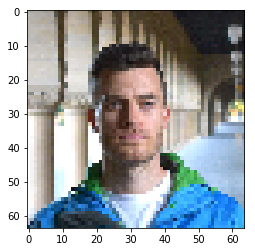

In [15]:
### START CODE HERE ###
img_path = 'images/noahface.jpg'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))

## 5 - Other useful functions in Keras (Optional)

Two other basic features of Keras that you'll find useful are:
- `model.summary()`: prints the details of your layers in a table with the sizes of its inputs/outputs
- `plot_model()`: plots your graph in a nice layout. You can even save it as ".png" using SVG() if you'd like to share it on social media ;). It is saved in "File" then "Open..." in the upper bar of the notebook.

Run the following code.

In [16]:
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

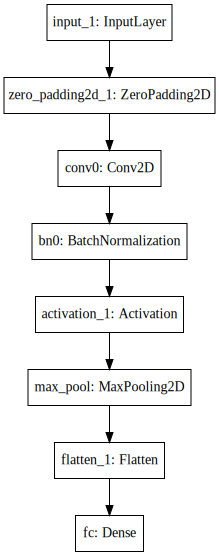

In [17]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))